In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("Glucose_Level_Estimation.csv")

# Convert height from feet → meters
df["HEIGHT"] = (df["HEIGHT"] * 0.3048).round(2)

# Encode diabetic status
df["DIABETIC"] = df["DIABETIC"].map({"N": 0, "Y": 1})

# One-hot encode gender
df = pd.get_dummies(df, columns=["GENDER"], drop_first=True)

# Drop sensitive / impractical columns
df = df.drop(columns=["SKIN_COLOR", "LAST_EATEN", "NIR_Reading", "HR_IR"])

df.head()

,AGE,WEIGHT,HEARTRATE,HEIGHT,DIABETIC,GLUCOSE_LEVEL,GENDER_M
0,22,42.0,62.0,1.62,0.0,110,False
1,22,76.0,98.0,1.77,0.0,93,False
2,22,40.0,70.0,1.55,0.0,75,False
3,21,64.0,108.0,1.62,0.0,228,False
4,21,40.0,64.0,1.62,0.0,133,False


In [4]:
for col in df.columns:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

In [5]:
X = df.drop(columns=["GLUCOSE_LEVEL"])
y = df["GLUCOSE_LEVEL"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)

In [6]:
linear_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

linear_pipeline.fit(X_train, y_train)
y_pred_lr = linear_pipeline.predict(X_test)

print("Ridge Regression")
print("R²:", r2_score(y_test, y_pred_lr))
rmse = mean_squared_error(y_test, y_pred_lr) ** 0.5
print("RMSE:", rmse)


Ridge Regression
R²: 0.5185773947542341
RMSE: 61.91278769838409


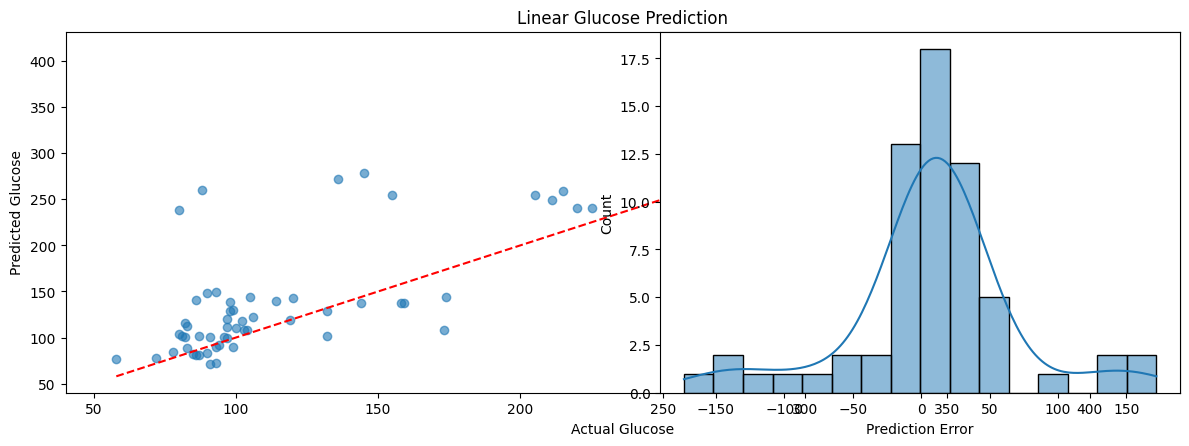

In [7]:
plt.figure(figsize=(12,5))
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.xlabel("Actual Glucose")
plt.ylabel("Predicted Glucose")
plt.title("Linear Glucose Prediction")

plt.subplot(1,2,2)
sns.histplot(y_pred_lr - y_test, kde=True)
plt.xlabel('Prediction Error')
plt.tight_layout()
plt.show()

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def glucose_to_class(glucose):
    if glucose < 70:
        return 0
    elif glucose < 140:
        return 1
    elif glucose < 200:
        return 2
    else:
        return 3
y_test_class = y_test.apply(glucose_to_class)
y_pred_class = pd.Series(y_pred_lr).apply(glucose_to_class)


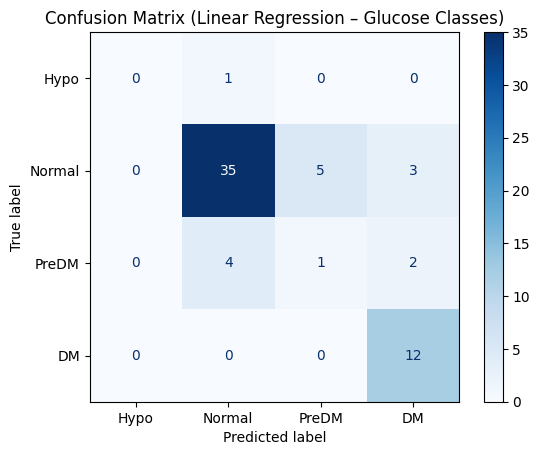

In [9]:
cm = confusion_matrix(y_test_class, y_pred_class)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Hypo", "Normal", "PreDM", "DM"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Linear Regression – Glucose Classes)")
plt.show()


In [10]:
svr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR(kernel="rbf", C=100, gamma=0.05, epsilon=5))
])

svr_pipeline.fit(X_train, y_train)
y_pred_svr = svr_pipeline.predict(X_test)

rmse_svr = mean_squared_error(y_test, y_pred_svr) ** 0.5
r2_svr = r2_score(y_test, y_pred_svr)

print("\nSVR")
print("R²:", r2_svr)
print("RMSE:", rmse_svr)



SVR
R²: 0.5413330748374948
RMSE: 60.43184195337651


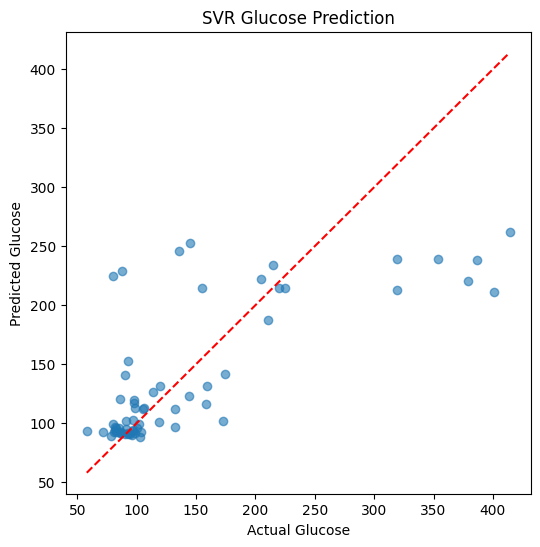

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_svr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.xlabel("Actual Glucose")
plt.ylabel("Predicted Glucose")
plt.title("SVR Glucose Prediction")
plt.show()


In [12]:
joblib.dump(linear_pipeline, "glucose_model.pkl")

['glucose_model.pkl']